# Extract stock data from Yahoo Finance

Here’s a full modular pipeline in Python that:

Downloads daily price data and resamples quarterly

Extracts key quarterly momentum features

Fetches quarterly fundamental and other features from yfinance

Handles missing data smartly

Creates a binary target variable (buy/sell) based on future returns

Returns a flat DataFrame ready for ML modeling



Function defitions:

* get_price_features: downloads daily data, resamples quarterly, computes returns, volatility, momentum.

* get_fundamental_features: grabs the latest fundamentals, institutional holdings, ESG, dividends, recommendations.

* build_quarterly_dataset: merges both, cleans missing values, creates a binary future return target.



#### TODO
* MACD calculation
* difference between OPEn and CLOSE prices and HIGh vs LOW
* add Macro params


In [195]:
import yfinance as yf

import pandas as pd
import numpy as np

from datetime import datetime
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [196]:
tickers = pd.read_csv('tickers.csv')
tickers.head()

,country,ticker,company,sector
0,USA,AAPL,Apple,IT
1,USA,MSFT,Microsoft,IT
2,USA,NVDA,NVIDIA,IT
3,USA,ORCL,Oracle,IT
4,USA,IBM,IBM,IT


In [197]:
tickers_list = tickers['ticker'].tolist()
len(tickers_list)

14

In [198]:
# Define the start and end dates for the data retrieval
start_date = '2000-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
end_date

'2025-06-05'

### 1. Fetch Closing price

In [200]:
def get_price_features(ticker, start, end): 
    """
    Download daily prices, resample quarterly, create momentum, volatility,
    and quarterly moving average features.
    """
    try:
        df = yf.Ticker(ticker).history(start=start, end=end, interval='1d')[['Close']]
        if df.empty:
            print(f"No price data for {ticker}")
            return pd.DataFrame()
        
        # Resample to quarter-end close price
        df = df.resample('QE').last()
        #historical growth rate
        df['return_1q'] = df['Close'].pct_change(1)
        df['return_2q'] = df['Close'].pct_change(2)
        df['return_3q'] = df['Close'].pct_change(3)
        df['return_4q'] = df['Close'].pct_change(4)
        df['vol_3q'] = df['Close'].pct_change().rolling(window=3).std()
        df['momentum_3q'] = df['return_3q'] / df['vol_3q']  # Sharpe proxy

        # quarterly moving averages
        df['qma_2'] = df['Close'].rolling(window=2).mean()
        df['qma_4'] = df['Close'].rolling(window=4).mean()
        df['qma_8'] = df['Close'].rolling(window=8).mean()

        # crossover signals (for modeling or visualizations)
        df['buy_signal'] = (df['qma_2'] > df['qma_4']) & (df['qma_2'].shift(1) <= df['qma_4'].shift(1))
        df['sell_signal'] = (df['qma_2'] < df['qma_4']) & (df['qma_2'].shift(1) >= df['qma_4'].shift(1))

        df = df.dropna()
        df.reset_index(inplace=True)

        # Convert to datetime and remove timezone
        df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)

        # Extract year and quarter
        df['year'] = df['Date'].dt.year
        df['quarter'] = df['Date'].dt.quarter.astype(str)

        df['ticker'] = ticker
        return df

    except Exception as e:
        print(f"[PRICE] Error for {ticker}: {e}")
        return pd.DataFrame()


In [201]:
def get_fundamental_features(ticker, end):
    """
    Fetch fundamental & metadata features from yfinance, return as dict.
    """
    try:
        tk = yf.Ticker(ticker)
        info = tk.get_info() or {}
        bs = tk.get_balance_sheet()
        cf = tk.get_cashflow()
        holders = tk.get_institutional_holders()
        sustainability = tk.get_sustainability()
        recommendations = tk.get_recommendations()
        calendar = tk.get_calendar()

        # Ensure to take the latest available data from balance sheet
        def safe_get_latest(bs_df, row_name):
            if bs_df is not None and row_name in bs_df.index:
                series = bs_df.loc[row_name].dropna()
                if not series.empty:
                    return series.iloc[0]
            return np.nan
 
        # Fundamental ratios

        # BS parameters
        total_assets = safe_get_latest(bs, 'TotalAssets')
        total_liabilities = safe_get_latest(bs, 'TotalLiabilitiesNetMinorityInterest')
        total_equity = safe_get_latest(bs, 'StockholdersEquity')
        long_term_debt = safe_get_latest(bs, 'LongTermDebt')
        current_assets = safe_get_latest(bs, 'CurrentAssets')
        current_liabilities = safe_get_latest(bs, 'CurrentLiabilities')
        cash_equivalents = safe_get_latest(bs, 'CashAndCashEquivalents')
        retained_earnings = safe_get_latest(bs, 'RetainedEarnings')
        working_capital = safe_get_latest(bs, 'WorkingCapital')

        debt_to_equity = total_liabilities / total_equity if total_equity else np.nan
        current_ratio = current_assets / current_liabilities if current_liabilities else np.nan
        cash_ratio = cash_equivalents / current_liabilities if current_liabilities else np.nan
        working_capital_ratio = working_capital / total_assets if total_assets else np.nan
        retained_earnings_to_assets = retained_earnings / total_assets if total_assets else np.nan
        long_term_debt_to_equity = long_term_debt / total_equity if total_equity else np.nan


        op_cf = cf.loc['OperatingCashFlow'].iloc[0] if cf is not None and 'OperatingCashFlow' in cf.index else None
        revenue = info.get('totalRevenue')
        operating_cf_margin = op_cf / revenue if op_cf and revenue else np.nan
        

        free_cf = cf.loc['FreeCashFlow'].iloc[0] if cf is not None and 'FreeCashFlow' in cf.index else None
        free_cf_margin = free_cf / revenue if free_cf and revenue else np.nan

        # Institutional holders
        pct_held = holders['pctHeld'].mean() if holders is not None and not holders.empty else np.nan
        inst_count = len(holders) if holders is not None else np.nan

        # ESG scores
        esg_env = sustainability.loc['environmentScore'].iloc[0] if sustainability is not None and 'environmentScore' in sustainability.index else np.nan
        esg_soc = sustainability.loc['socialScore'].iloc[0] if sustainability is not None and 'socialScore' in sustainability.index else np.nan
        esg_gov = sustainability.loc['governanceScore'].iloc[0] if sustainability is not None and 'governanceScore' in sustainability.index else np.nan

        # Recommendations count last 90 days
        recent_reco = 0
        if recommendations is not None and not recommendations.empty:
            recent_months = recommendations[recommendations['period'].isin(['0m', '-1m', '-2m', '-3m'])]
            recent_reco = recent_months[['strongBuy', 'buy', 'hold', 'sell', 'strongSell']].sum().sum()
            strong_to_total_ratio = recent_months['strongBuy'].sum() / recent_reco if recent_reco else np.nan

        # Days to next earnings
        days_to_earnings = np.nan
        if calendar and isinstance(calendar, dict) and 'Earnings Date' in calendar:
            earnings_dates = calendar['Earnings Date']
            if isinstance(earnings_dates, list) and len(earnings_dates) > 0:
                earnings_date = earnings_dates[0]
                if isinstance(earnings_date, (datetime.date, datetime.datetime)):
                    earnings_datetime = pd.to_datetime(earnings_date)
                    days_to_earnings = (earnings_datetime - pd.to_datetime(end)).days
        
        # Dividend stability: std of yearly dividend sums / mean dividend sums
        actions = tk.get_actions()
        dividend_stability = np.nan
        if actions is not None and 'Dividends' in actions.columns:
            yearly_divs = actions['Dividends'].resample('YE').sum()
            if len(yearly_divs) > 1 and yearly_divs.mean() != 0:
                dividend_stability = yearly_divs.std() / yearly_divs.mean()

        return {
            'marketCap': info.get('marketCap', np.nan),
            'beta': info.get('beta', np.nan),
            'trailingPE': info.get('trailingPE', np.nan),
            'forwardPE': info.get('forwardPE', np.nan),
            'trailing_PEG': info.get('trailingPegRatio', np.nan),
            'priceToBook': info.get('priceToBook', np.nan),
            'dividendYield': info.get('dividendYield', np.nan),
            'debt_to_equity': debt_to_equity,
            'debt_to_equity': debt_to_equity,
            'current_ratio': current_ratio,
            'cash_ratio': cash_ratio,
            'working_capital': working_capital,
            'working_capital_ratio': working_capital_ratio,
            'retained_earnings_to_assets': retained_earnings_to_assets,
            'long_term_debt_to_equity': long_term_debt_to_equity,
            'operating_cf_margin': operating_cf_margin,
            'free_cf_margin': free_cf_margin,
            'pct_held_by_inst': pct_held,
            'institutional_holders_count': inst_count,
            'esg_env': esg_env,
            'esg_soc': esg_soc,
            'esg_gov': esg_gov,
            'recent_rating_changes': recent_reco,
            'strong_to_total_reco_ratio': strong_to_total_ratio,
            'days_to_next_earnings': days_to_earnings,
            'dividend_stability': dividend_stability,
            'companyName': info.get('shortName', np.nan),
            'sector': info.get('sector'),
            'industry': info.get('industry'),
            'country': info.get('country'),
            'fullTimeEmployees': info.get('fullTimeEmployees', np.nan),
        }
    except Exception as e:
        print(f"[FUNDAMENTAL] Error for {ticker}: {e}")
        return {}


In [202]:
def build_quarterly_dataset(tickers, start_date, end_date):
    """
    Build full feature dataset for ML training:
    - Quarterly price momentum & volatility features
    - Latest fundamental features (same for all quarters)
    - Target variable: future quarter return median split
    """
    all_rows = []
    for ticker in tickers:
        print(f"Processing {ticker}")
        price_df = get_price_features(ticker, start_date, end_date)
        if price_df.empty:
            print(f"No price data for {ticker}, skipping")
            continue
        fund_feats = get_fundamental_features(ticker, end_date)
        if not fund_feats:
            print(f"No fundamental data for {ticker}, skipping")
            continue
        # Merge features
        for idx, row in price_df.iterrows():
            data = {
                'ticker': ticker,
                'date': row['Date'],
                'year': row['year'],
                'quarter': row['quarter'],
                'close': row['Close'],
                'return_1q': row['return_1q'],
                'return_2q': row['return_2q'],
                'return_3q': row['return_3q'],
                'vol_3q': row['vol_3q'],
                'momentum_3q': row['momentum_3q'],
                'qma_2': row['qma_2'],
                'qma_4': row['qma_4'],
                'qma_8': row['qma_8'],
                'buy_signal': row['buy_signal'],
                'sell_signal': row['sell_signal']
            }
            data.update(fund_feats)
            all_rows.append(data)

    df = pd.DataFrame(all_rows)

    # Target: future quarter return > median -> 1 else 0
    #df = df.sort_values(['ticker', 'date'])
    #df['future_return'] = df.groupby('ticker')['close'].shift(-1) / df['close'] - 1
    #median_return = df['future_return'].median()
    #df['target'] = (df['future_return'] > median_return).astype(int)
    #df = df.drop(columns=['future_return'])
    return df


In [203]:
df = build_quarterly_dataset(tickers_list, start_date, end_date)
df.head()

Processing AAPL
Processing MSFT
Processing NVDA
Processing ORCL
Processing IBM
Processing JNJ
Processing PFE
Processing MRK
Processing ABBV
Processing UNH
Processing SAP.DE
Processing IFX.DE
Processing FME.DE
Processing SHL.DE


,ticker,date,year,quarter,close,return_1q,return_2q,return_3q,vol_3q,momentum_3q,...,esg_gov,recent_rating_changes,strong_to_total_reco_ratio,days_to_next_earnings,dividend_stability,companyName,sector,industry,country,fullTimeEmployees
0,AAPL,2001-12-31,2001,4,0.329093,0.411991,-0.058067,-0.007704,0.372535,-0.020679,...,8.58,185,0.145946,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
1,AAPL,2002-03-31,2002,1,0.355692,0.080824,0.526115,0.018064,0.373210,0.048402,...,8.58,185,0.145946,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
2,AAPL,2002-06-30,2002,2,0.266280,-0.251373,-0.190866,0.142491,0.331682,0.429599,...,8.58,185,0.145946,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
3,AAPL,2002-09-30,2002,3,0.217893,-0.181715,-0.387410,-0.337898,0.175183,-1.928829,...,8.58,185,0.145946,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
4,AAPL,2002-12-31,2002,4,0.215338,-0.011725,-0.191310,-0.394593,0.123275,-3.200925,...,8.58,185,0.145946,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000


In [204]:
df.shape

(1205, 45)

# EDA Visualization

### 1. Stock Price over the time

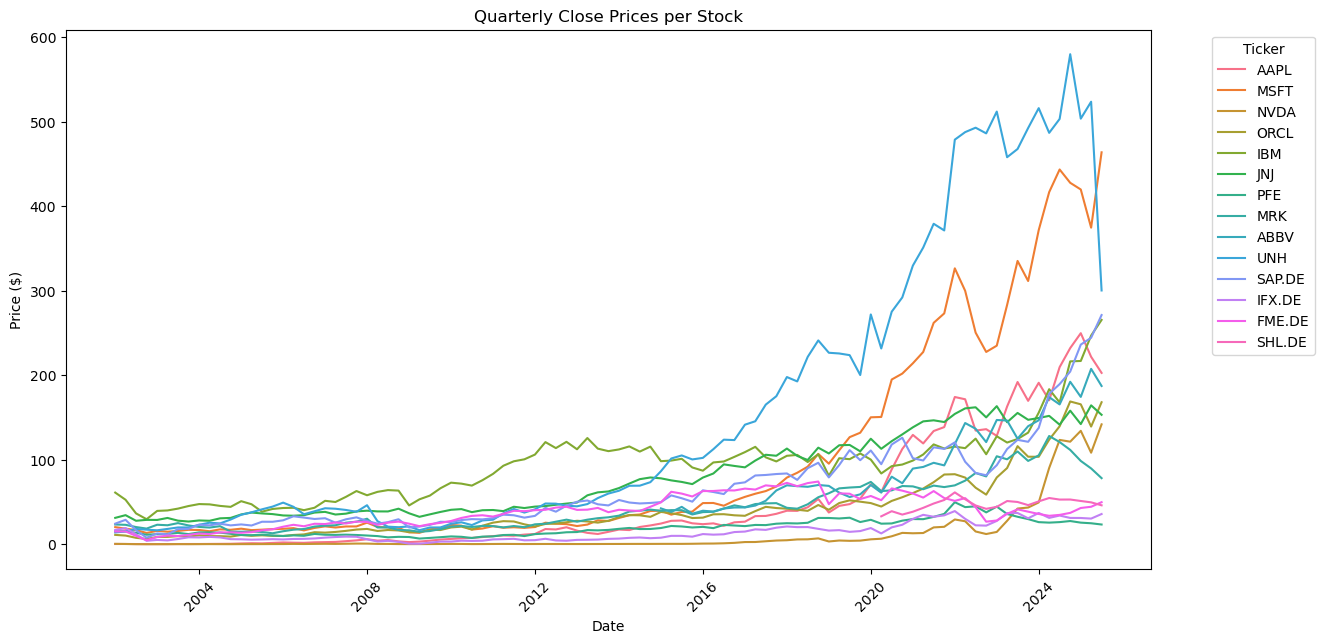

In [205]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=df, x='date', y='close', hue='ticker')
plt.title("Quarterly Close Prices per Stock")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.legend(title='Ticker', bbox_to_anchor=(1.05, 1), loc='upper left')

### 2. Missing data heatmap

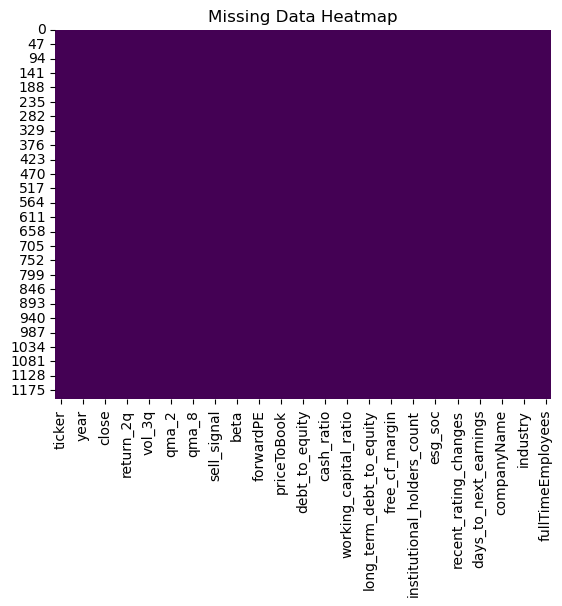

In [206]:
sns.heatmap(df.isna(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

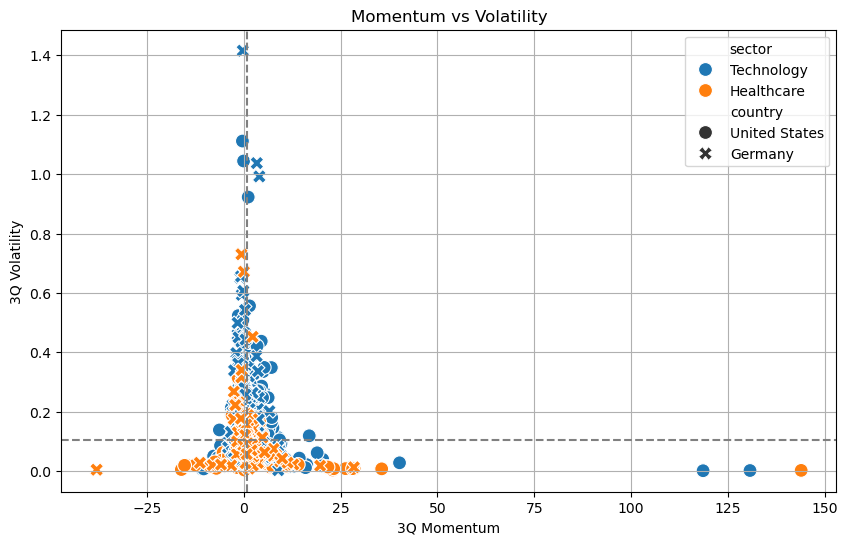

In [207]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='momentum_3q', y='vol_3q', hue='sector', style='country', s=100)
plt.axhline(df['vol_3q'].median(), linestyle='--', color='grey')
plt.axvline(df['momentum_3q'].median(), linestyle='--', color='grey')
plt.title('Momentum vs Volatility')
plt.xlabel('3Q Momentum')
plt.ylabel('3Q Volatility')
plt.grid(True)
plt.show()

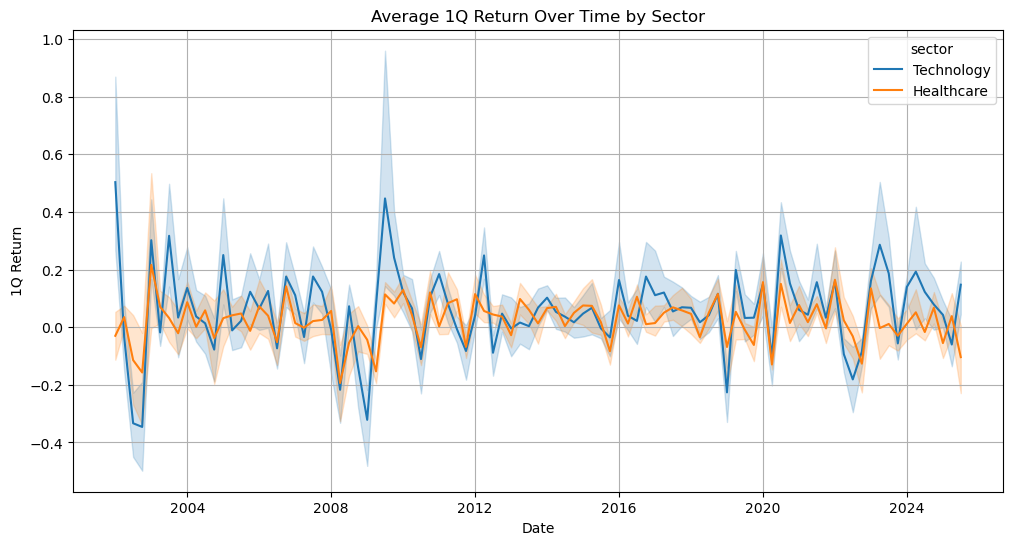

In [208]:

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='date', y='return_1q', hue='sector', estimator='mean')
plt.title('Average 1Q Return Over Time by Sector')
plt.ylabel('1Q Return')
plt.xlabel('Date')
plt.grid(True)
plt.show()

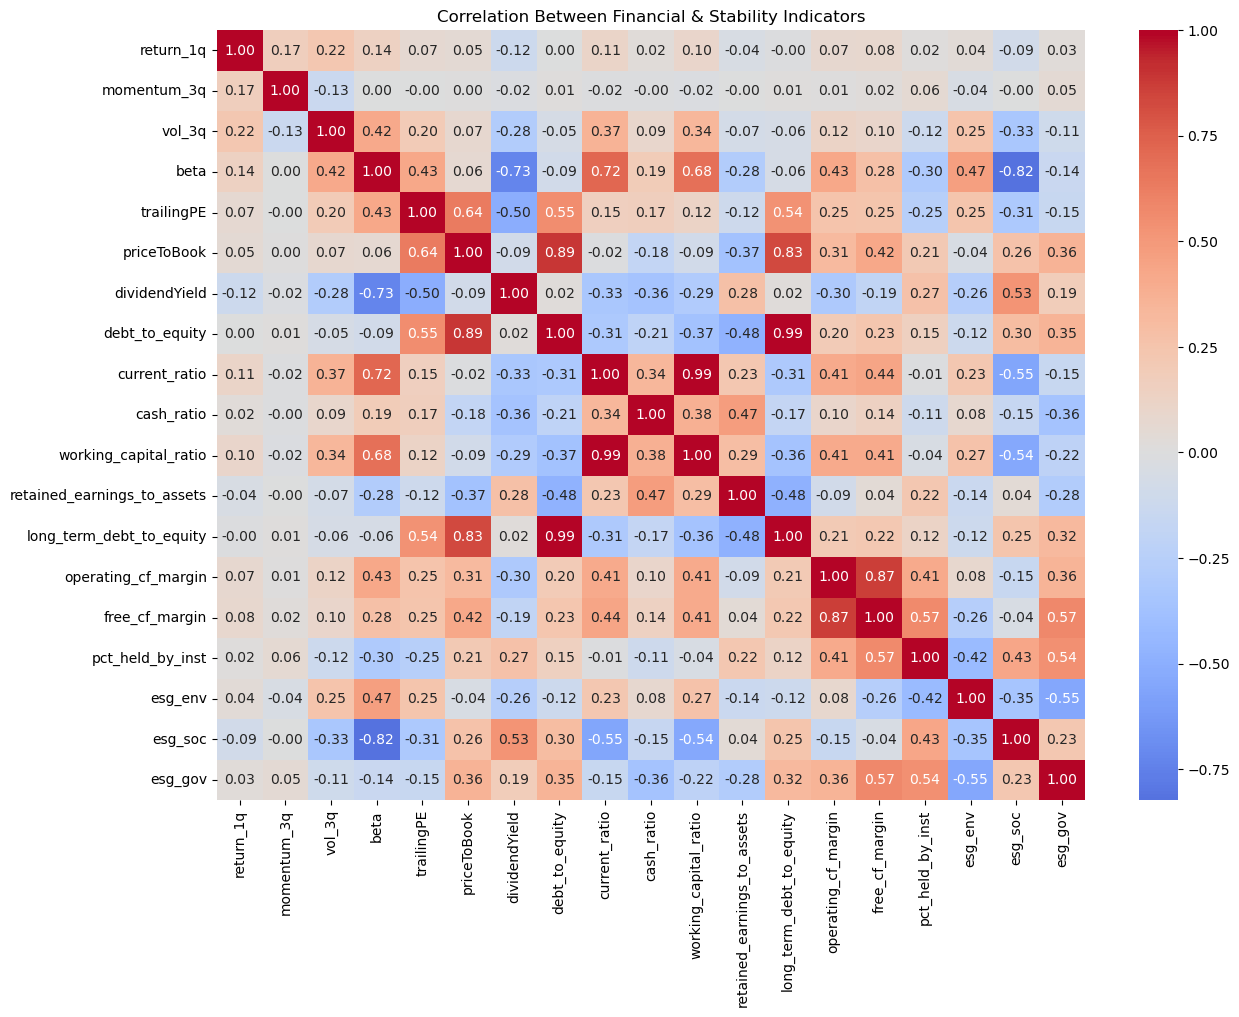

In [209]:
numeric_cols = [
    'return_1q', 'momentum_3q', 'vol_3q',
    'beta', 'trailingPE', 'priceToBook', 'dividendYield',
    'debt_to_equity', 'current_ratio', 'cash_ratio', 'working_capital_ratio',
    'retained_earnings_to_assets', 'long_term_debt_to_equity',
    'operating_cf_margin', 'free_cf_margin', 'pct_held_by_inst',
    'esg_env', 'esg_soc', 'esg_gov'
]

plt.figure(figsize=(14, 10))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Between Financial & Stability Indicators")
plt.show()

In [210]:
df.columns

Index(['ticker', 'date', 'year', 'quarter', 'close', 'return_1q', 'return_2q',
       'return_3q', 'vol_3q', 'momentum_3q', 'qma_2', 'qma_4', 'qma_8',
       'buy_signal', 'sell_signal', 'marketCap', 'beta', 'trailingPE',
       'forwardPE', 'trailing_PEG', 'priceToBook', 'dividendYield',
       'debt_to_equity', 'current_ratio', 'cash_ratio', 'working_capital',
       'working_capital_ratio', 'retained_earnings_to_assets',
       'long_term_debt_to_equity', 'operating_cf_margin', 'free_cf_margin',
       'pct_held_by_inst', 'institutional_holders_count', 'esg_env', 'esg_soc',
       'esg_gov', 'recent_rating_changes', 'strong_to_total_reco_ratio',
       'days_to_next_earnings', 'dividend_stability', 'companyName', 'sector',
       'industry', 'country', 'fullTimeEmployees'],
      dtype='object')

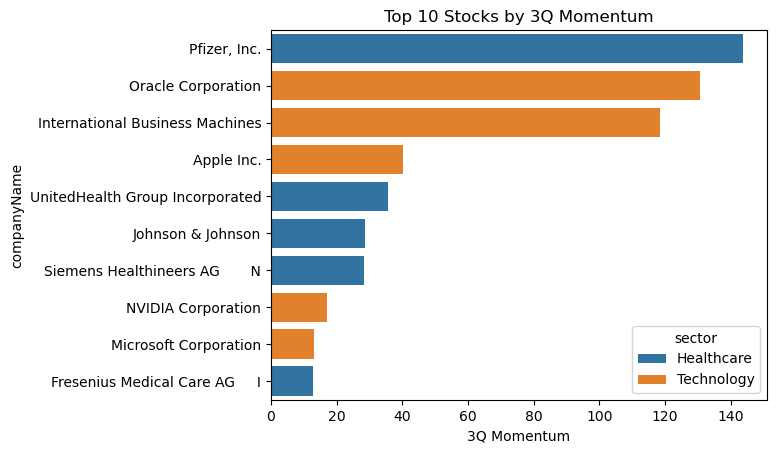

In [211]:
top_momentum = df.sort_values('momentum_3q', ascending=False).drop_duplicates('ticker').head(10)
sns.barplot(data=top_momentum, x='momentum_3q', y='companyName', hue='sector')
plt.title('Top 10 Stocks by 3Q Momentum')
plt.xlabel('3Q Momentum')
plt.ylabel('companyName')
plt.show()

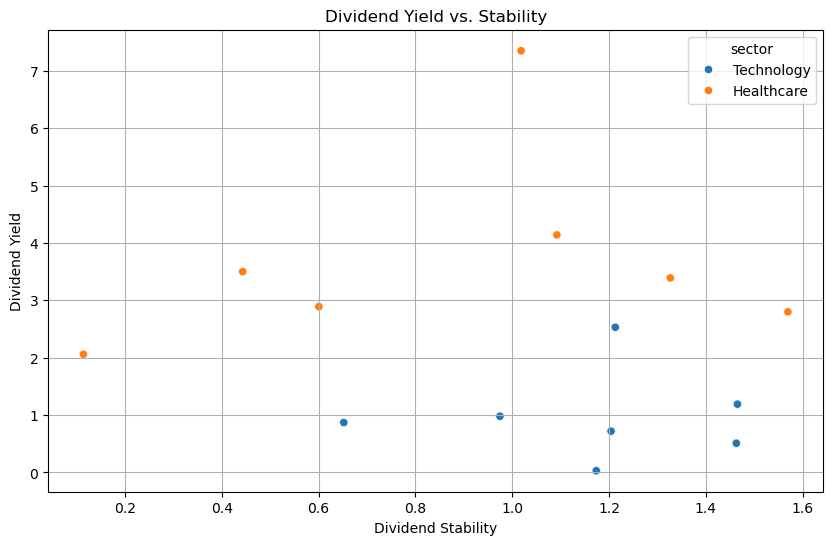

In [149]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='dividend_stability', y='dividendYield', hue='sector')
plt.title('Dividend Yield vs. Stability')
plt.xlabel('Dividend Stability')
plt.ylabel('Dividend Yield')
plt.grid(True)
plt.show()

In [174]:
df

,ticker,date,close,return_1q,return_2q,return_3q,vol_3q,momentum_3q,qma_2,qma_4,...,esg_soc,esg_gov,recent_rating_changes,days_to_next_earnings,dividend_stability,companyName,sector,industry,country,fullTimeEmployees
0,AAPL,2001-12-31 00:00:00-05:00,0.329093,0.411991,-0.058067,-0.007704,0.372535,-0.020679,0.281081,0.310798,...,7.98,8.58,185,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
1,AAPL,2002-03-31 00:00:00-05:00,0.355692,0.080824,0.526115,0.018064,0.373210,0.048402,0.342392,0.316809,...,7.98,8.58,185,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
2,AAPL,2002-06-30 00:00:00-04:00,0.266280,-0.251373,-0.190866,0.142491,0.331682,0.429599,0.310986,0.296034,...,7.98,8.58,185,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
3,AAPL,2002-09-30 00:00:00-04:00,0.217893,-0.181715,-0.387410,-0.337898,0.175183,-1.928829,0.242087,0.292240,...,7.98,8.58,185,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
4,AAPL,2002-12-31 00:00:00-05:00,0.215338,-0.011725,-0.191310,-0.394593,0.123275,-3.200925,0.216616,0.263801,...,7.98,8.58,185,55,1.463044,Apple Inc.,Technology,Consumer Electronics,United States,164000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,SHL.DE,2024-06-30 00:00:00+02:00,52.909893,-0.033542,0.042158,0.142032,0.070189,2.023563,53.828030,51.188804,...,9.24,6.92,76,55,0.113855,Siemens Healthineers AG N,Healthcare,Medical Devices,Germany,72000
1201,SHL.DE,2024-09-30 00:00:00+02:00,52.968899,0.001115,-0.032464,0.043320,0.057267,0.756459,52.939396,52.848624,...,9.24,6.92,76,55,0.113855,Siemens Healthineers AG N,Healthcare,Medical Devices,Germany,72000
1202,SHL.DE,2024-12-31 00:00:00+01:00,51.238018,-0.032677,-0.031599,-0.064080,0.019764,-3.242216,52.103458,52.965744,...,9.24,6.92,76,55,0.113855,Siemens Healthineers AG N,Healthcare,Medical Devices,Germany,72000
1203,SHL.DE,2025-03-31 00:00:00+02:00,49.610001,-0.031774,-0.063413,-0.062368,0.019255,-3.239139,50.424009,51.681703,...,9.24,6.92,76,55,0.113855,Siemens Healthineers AG N,Healthcare,Medical Devices,Germany,72000


In [158]:
df.columns

Index(['ticker', 'date', 'close', 'return_1q', 'return_2q', 'return_3q',
       'vol_3q', 'momentum_3q', 'marketCap', 'beta', 'trailingPE', 'forwardPE',
       'trailing_PEG', 'priceToBook', 'dividendYield', 'debt_to_equity',
       'current_ratio', 'cash_ratio', 'working_capital',
       'working_capital_ratio', 'retained_earnings_to_assets',
       'long_term_debt_to_equity', 'operating_cf_margin', 'free_cf_margin',
       'pct_held_by_inst', 'institutional_holders_count', 'esg_env', 'esg_soc',
       'esg_gov', 'recent_rating_changes', 'days_to_next_earnings',
       'dividend_stability', 'companyName', 'sector', 'industry', 'country',
       'fullTimeEmployees'],
      dtype='object')

In [169]:
def plot_price_with_qma_signals(df, ticker):
    stock = df[df['ticker'] == ticker].copy()
    
    plt.figure(figsize=(14, 6))
    plt.plot(stock['date'], stock['close'], label='close', linewidth=2)
    plt.plot(stock['date'], stock['qma_2'], label='QMA2', linestyle='--')
    plt.plot(stock['date'], stock['qma_4'], label='QMA4', linestyle='--')
    plt.plot(stock['date'], stock['qma_8'], label='QMA8', linestyle=':')

    # Mark Buy/Sell signals
    plt.scatter(stock.loc[stock['buy_signal'], 'date'], 
                stock.loc[stock['buy_signal'], 'close'],
                marker='^', color='green', label='Buy Signal', zorder=5)
    plt.scatter(stock.loc[stock['sell_signal'], 'date'], 
                stock.loc[stock['sell_signal'], 'close'],
                marker='v', color='red', label='Sell Signal', zorder=5)

    plt.title(f'{df[df['ticker'] == ticker]['companyName'].values[0]}: Price with Quarterly Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [166]:
df.columns

Index(['ticker', 'date', 'close', 'return_1q', 'return_2q', 'return_3q',
       'vol_3q', 'momentum_3q', 'qma_2', 'qma_4', 'qma_8', 'buy_signal',
       'sell_signal', 'marketCap', 'beta', 'trailingPE', 'forwardPE',
       'trailing_PEG', 'priceToBook', 'dividendYield', 'debt_to_equity',
       'current_ratio', 'cash_ratio', 'working_capital',
       'working_capital_ratio', 'retained_earnings_to_assets',
       'long_term_debt_to_equity', 'operating_cf_margin', 'free_cf_margin',
       'pct_held_by_inst', 'institutional_holders_count', 'esg_env', 'esg_soc',
       'esg_gov', 'recent_rating_changes', 'days_to_next_earnings',
       'dividend_stability', 'companyName', 'sector', 'industry', 'country',
       'fullTimeEmployees'],
      dtype='object')

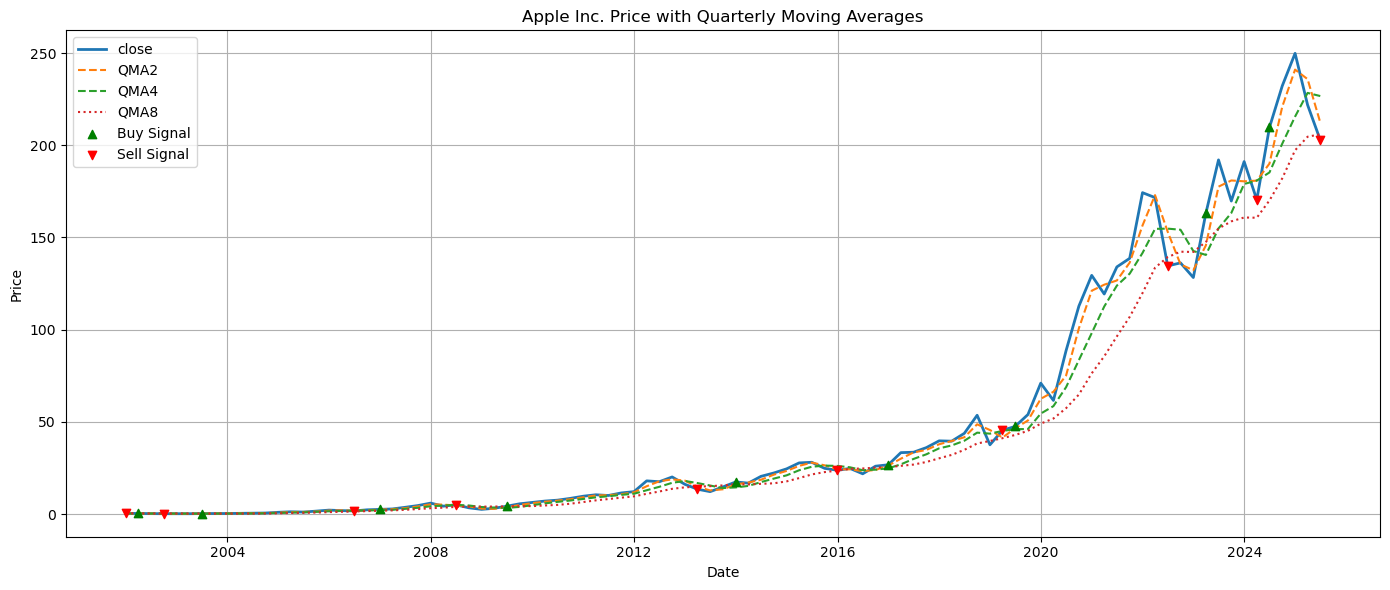

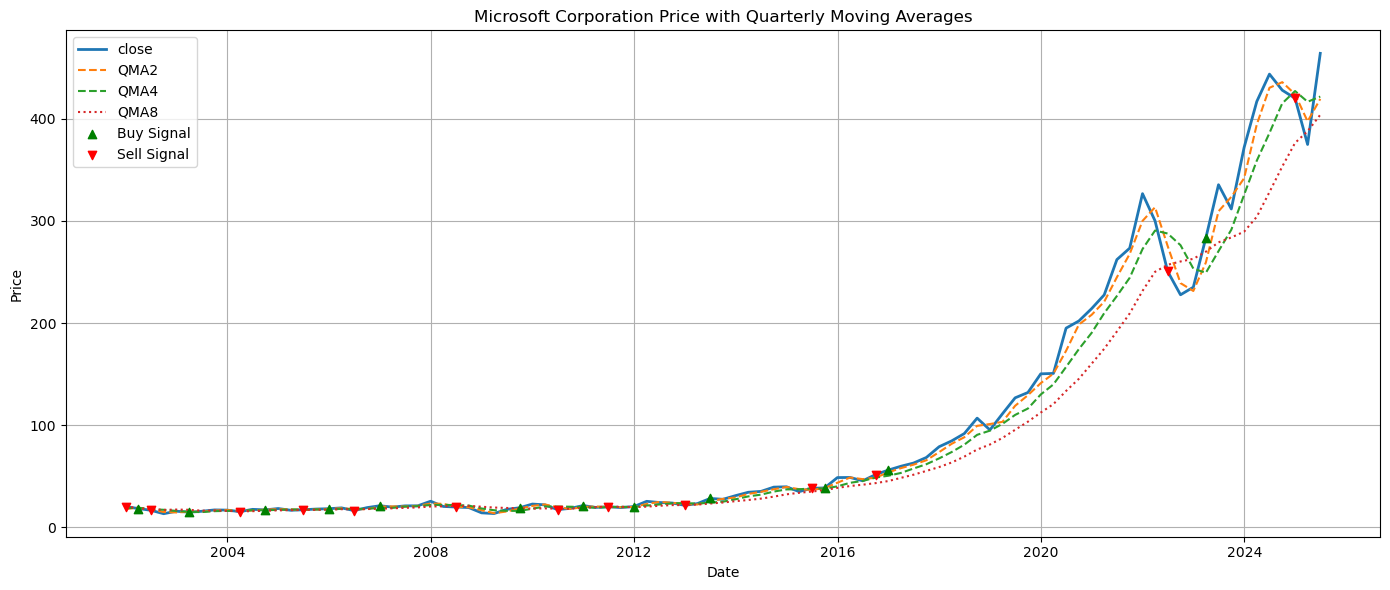

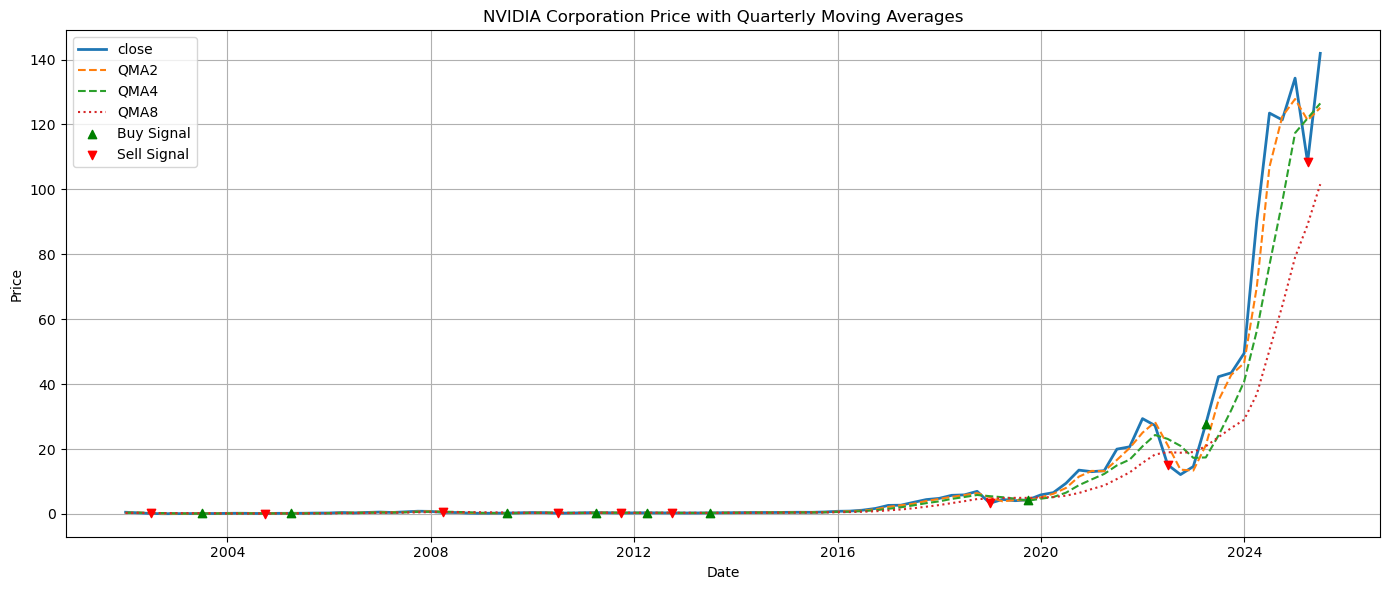

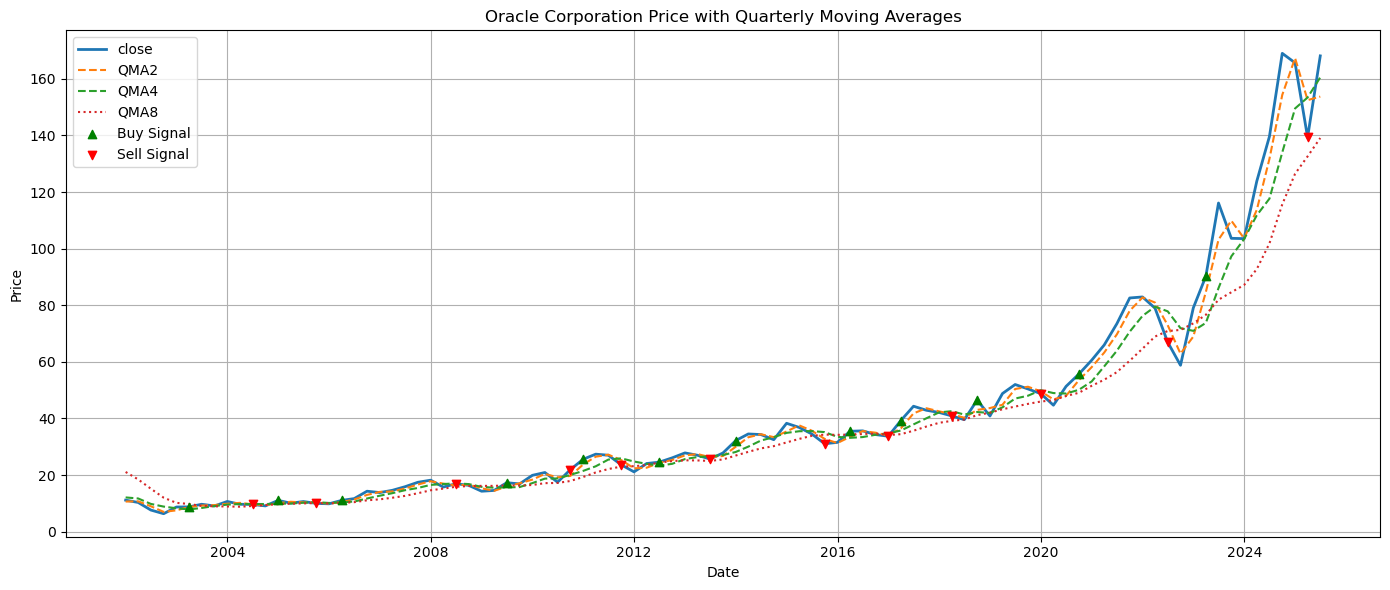

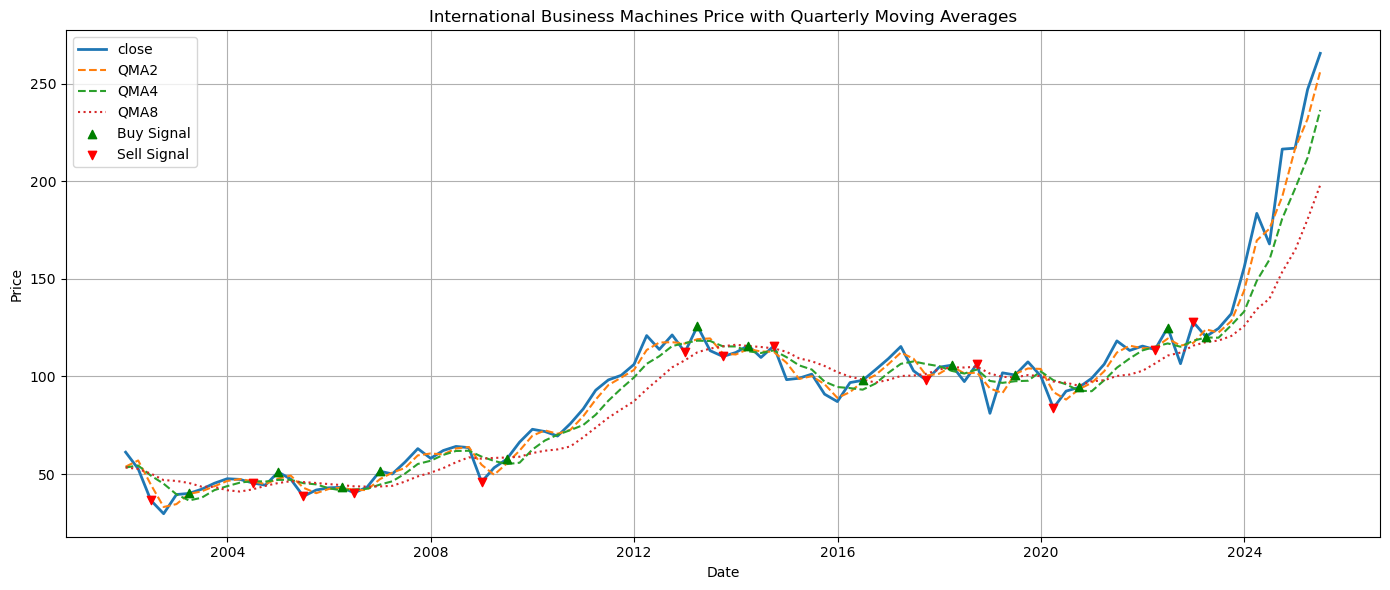

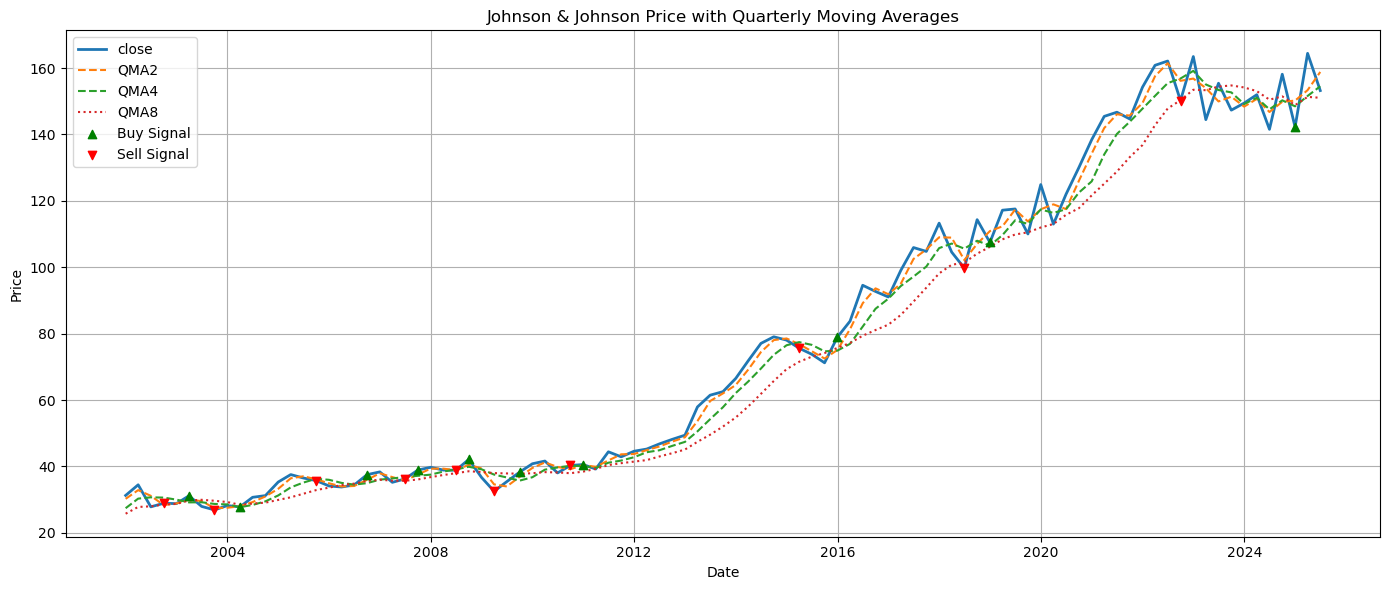

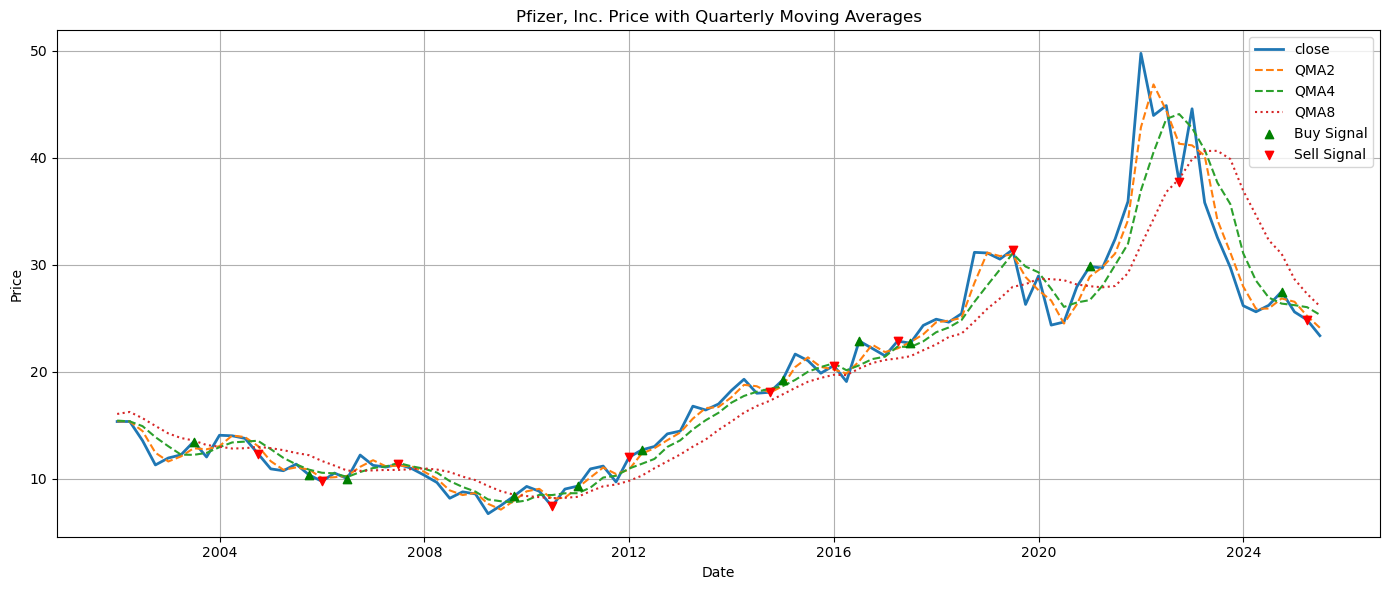

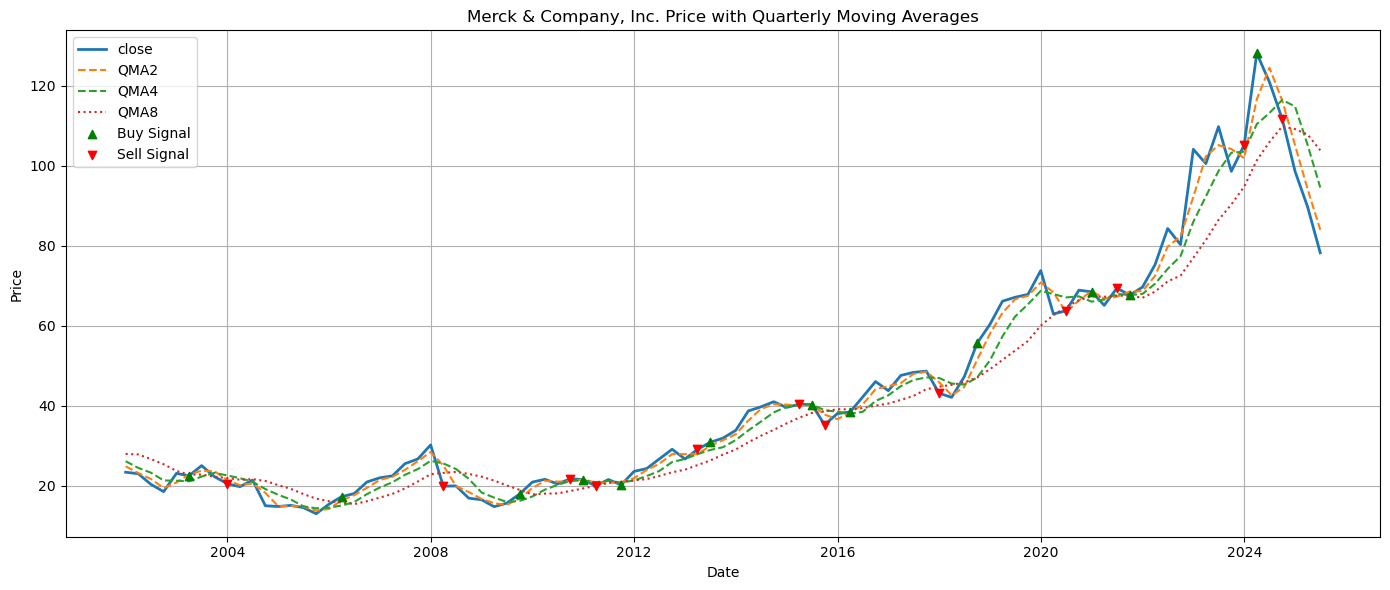

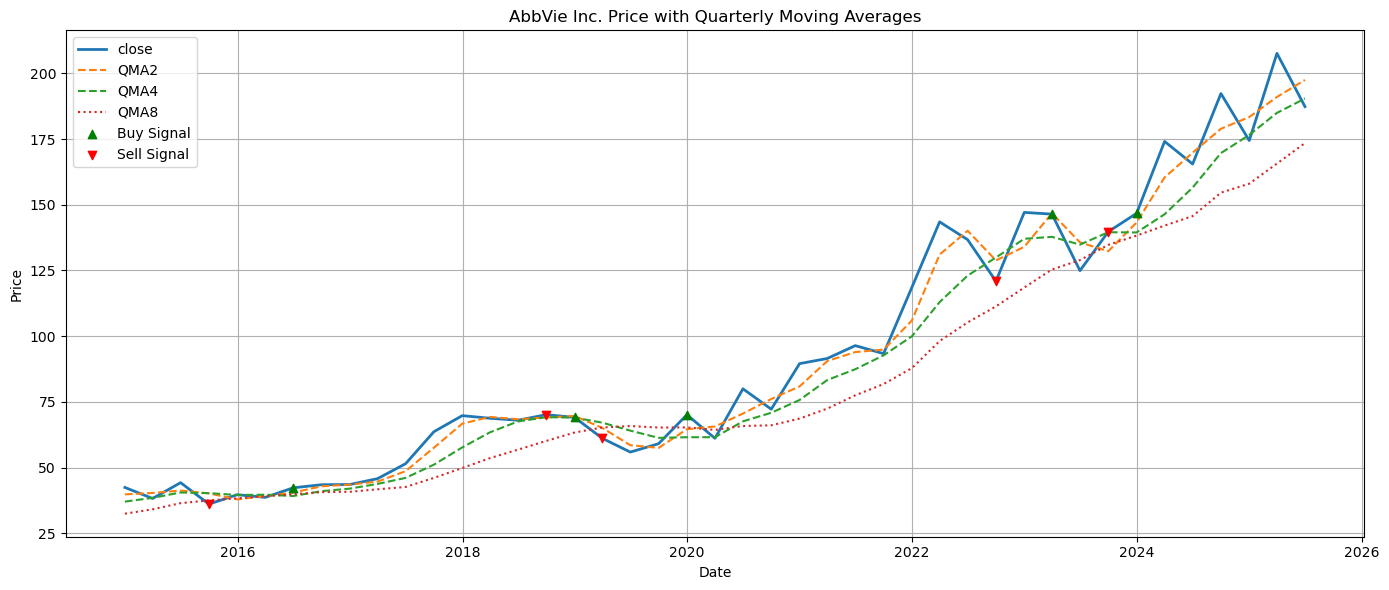

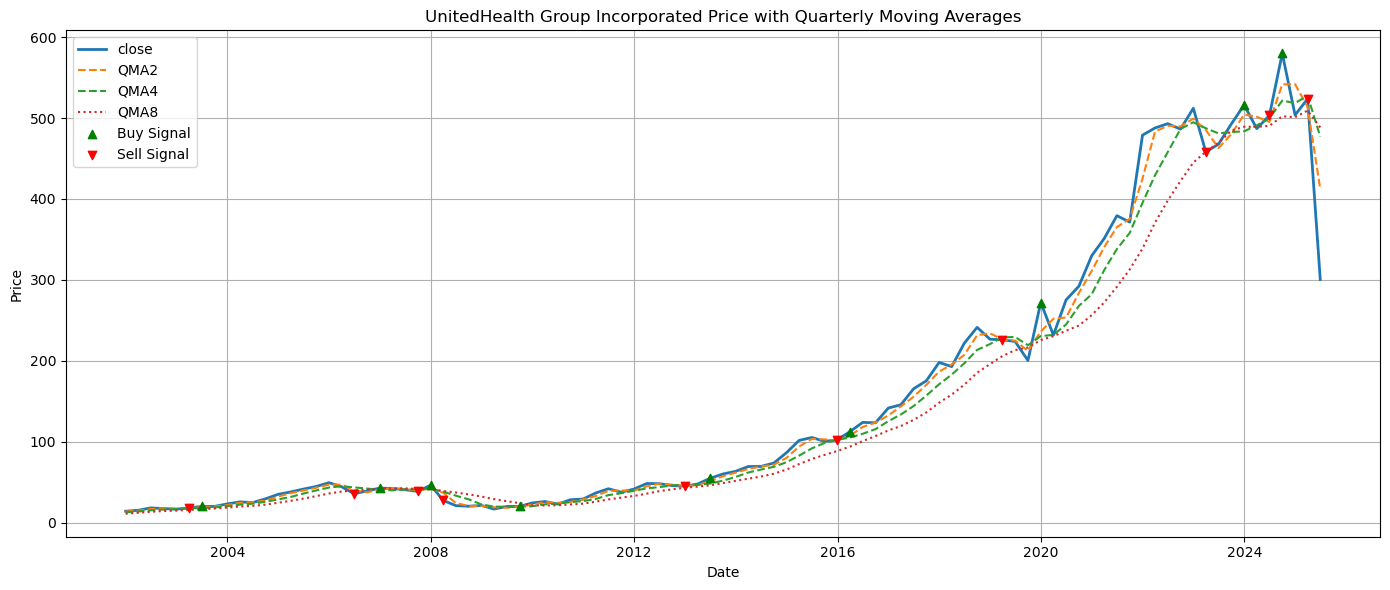

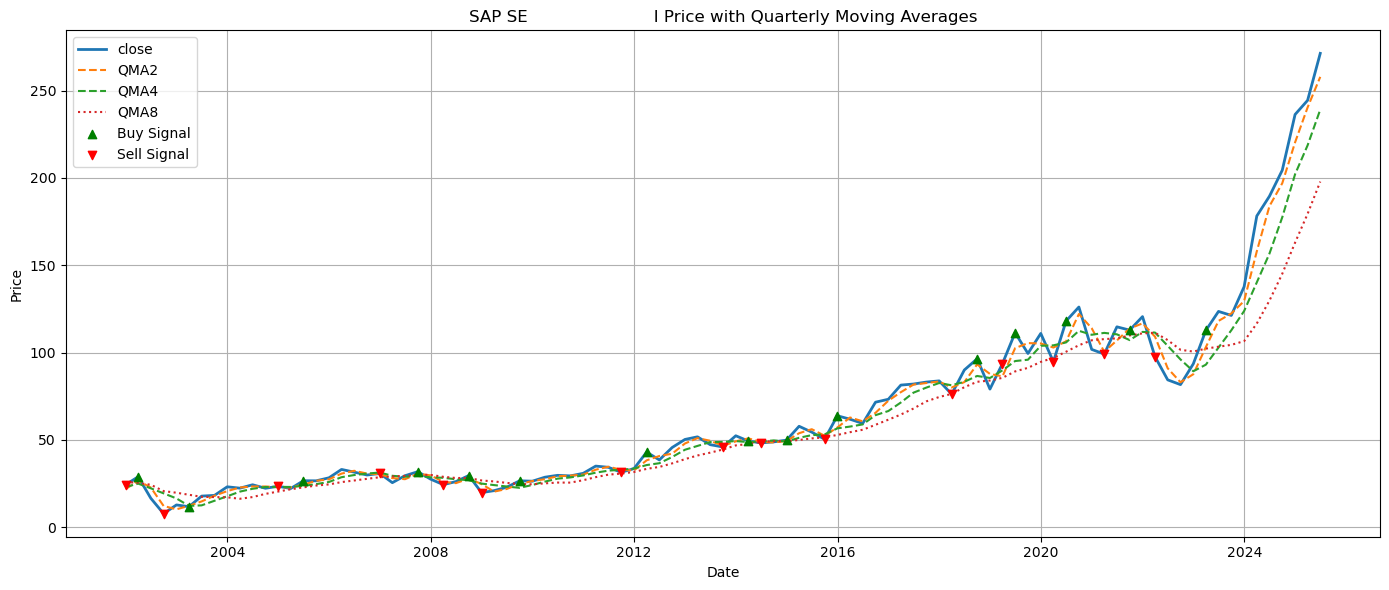

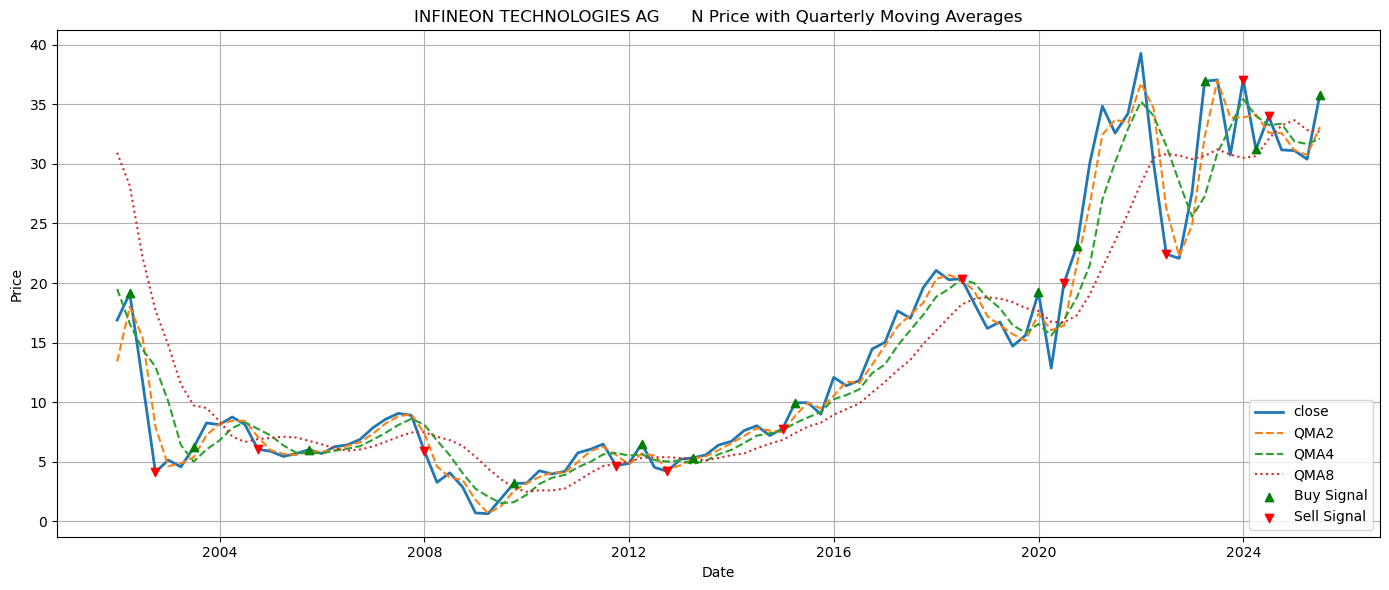

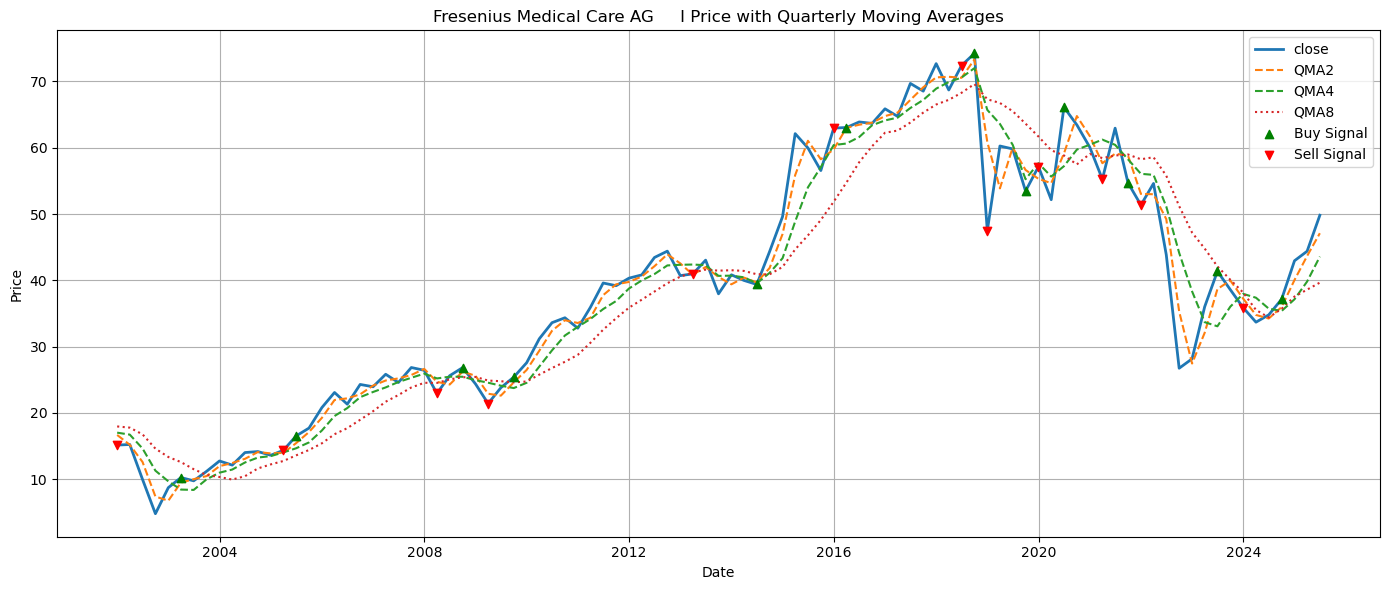

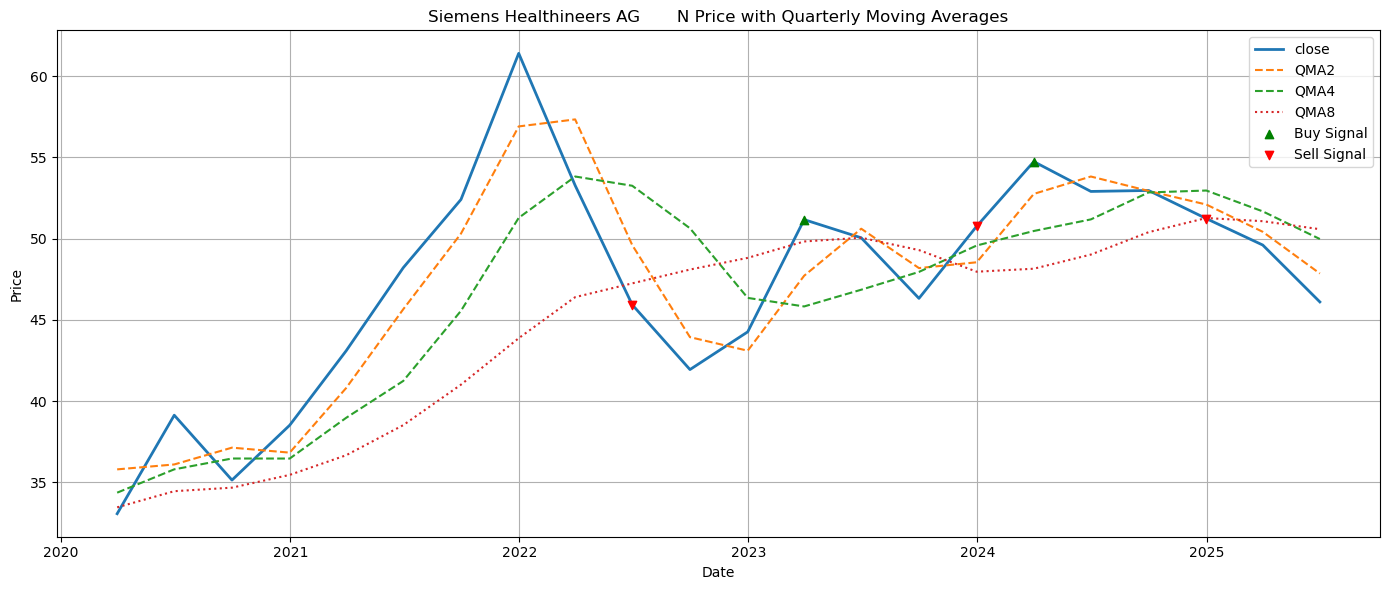

In [168]:
for ticker in df['ticker'].unique():
    plot_price_with_qma_signals(df, ticker)

In [127]:
df.columns

Index(['ticker', 'date', 'close', 'return_1q', 'return_2q', 'return_3q',
       'vol_3q', 'momentum_3q', 'marketCap', 'beta', 'trailingPE', 'forwardPE',
       'trailing_PEG', 'priceToBook', 'dividendYield', 'debt_to_equity',
       'current_ratio', 'cash_ratio', 'working_capital',
       'working_capital_ratio', 'retained_earnings_to_assets',
       'long_term_debt_to_equity', 'operating_cf_margin', 'free_cf_margin',
       'pct_held_by_inst', 'institutional_holders_count', 'esg_env', 'esg_soc',
       'esg_gov', 'recent_rating_changes', 'days_to_next_earnings',
       'dividend_stability', 'sector', 'industry', 'country',
       'fullTimeEmployees'],
      dtype='object')

In [ ]:
#tsla = yf.Ticker('JNJ')

# CALL THE MULTIPLE FUNCTIONS AVAILABLE AND STORE THEM IN VARIABLES.
#actions = tsla.get_actions()
#analysis = tsla.get_analysis()
#balance = tsla.get_balance_sheet()
#calendar = tsla.get_calendar()
#cf = tsla.get_cashflow()
#info = tsla.get_info()
#inst_holders = tsla.get_institutional_holders()
#news = tsla.get_news()
#recommendations = tsla.get_recommendations()
#sustainability = tsla.get_sustainability()


#info#.index

{'address1': 'One Johnson & Johnson Plaza',
 'city': 'New Brunswick',
 'state': 'NJ',
 'zip': '08933',
 'country': 'United States',
 'phone': '732 524 0400',
 'website': 'https://www.jnj.com',
 'industry': 'Drug Manufacturers - General',
 'industryKey': 'drug-manufacturers-general',
 'industryDisp': 'Drug Manufacturers - General',
 'sector': 'Healthcare',
 'sectorKey': 'healthcare',
 'sectorDisp': 'Healthcare',
 'longBusinessSummary': 'Johnson & Johnson, together with its subsidiaries, engages in the research and development, manufacture, and sale of various products in the healthcare field worldwide. It operates in two segments, Innovative Medicine and MedTech. The Innovative Medicine segment offers products for various therapeutic areas, such as immunology, including rheumatoid arthritis, psoriatic arthritis, inflammatory bowel disease, and psoriasis; infectious diseases comprising HIV/AIDS; neuroscience, consisting of mood disorders, neurodegenerative disorders, and schizophrenia; o